#Download dataset from kaggle:

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c cv2022spring

 97% 44.0M/45.4M [00:00<00:00, 118MB/s]
100% 45.4M/45.4M [00:00<00:00, 110MB/s]


In [ ]:
!unzip "/content/cv2022spring.zip" -d "/content/"

In [115]:
#remove directory
#!rm -rf /content/outputs

#merge train folders into one folder:

In [7]:
#Rename image name in train folder [image -> class_image]
import os

train_directory = '/content/train/train/train/'

for class_name in os.listdir(train_directory):
  folder = train_directory + class_name
  for file_name in os.listdir(folder):
      
      old_file_name = folder + "/" + file_name

      new_file_name = folder + "/"  + class_name[-3:] + "_" + file_name

      os.rename(old_file_name, new_file_name)

In [8]:
#https://www.geeksforgeeks.org/how-to-merge-multiple-folders-into-one-folder-using-python/

import shutil

#1.
#folder path
train_folder = '/content/train/train/train'
  
# list of folders to be merged
list_dir = os.listdir(train_folder)
  
# enumerate on list_dir to get the 
# content of all the folders ans store it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(train_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

#2.
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder_path):
      
    # Path
    path = os.path.join(parent_folder_path, folder_name)

    try: 
  
        # mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
          
    except OSError as error: 
        print(error)
  
# folder in which all the content 
# will be merged
merge_folder = "merge_folder"
merge_folder_path = os.path.join(train_folder, merge_folder) 
  
# create merge_folder if not exists
make_new_folder(merge_folder, train_folder)

#3.
# loop through the list of folders
for sub_dir in content_list:
  
    # loop through the contents of the
    # list of folders
    for contents in content_list[sub_dir]:
  
        # make the path of the content to move 
        path_to_content = sub_dir + "/" + contents  
  
        # make the path with the current folder
        dir_to_move = os.path.join(train_folder, path_to_content )
  
        # move the file
        shutil.move(dir_to_move, merge_folder_path)

#train data preprocessing:

In [ ]:
#mean/std overall train dataset (16239)
ff = '/content/train/train/train/merge_folder'
files_name = os.listdir(ff)
channels_sum, channels_squared_sum, num_batches = 0, 0, len(files_name)
for file_name in files_name:
    image = read_image(ff + "/" + file_name)
    image = image/255.0
    channels_sum += torch.mean(image, dim=[1,2])
    channels_squared_sum += torch.mean(image**2, dim=[1,2])
mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
print(mean, std)
#tensor([0.4786, 0.4556, 0.4054]) tensor([0.2577, 0.2497, 0.2651]) -> train
#tensor([0.4756, 0.4496, 0.3971]) tensor([0.2549, 0.2481, 0.2630]) -> test

In [9]:
from torch.utils.data import Dataset, DataLoader
import numpy
import random
import torch
import torchvision
from torchvision import transforms
from torchvision.io.image import read_image, ImageReadMode
import matplotlib.pyplot as plt

In [10]:
data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4786, 0.4556, 0.4054], std=[0.2577, 0.2497, 0.2651])])

def denormalize(img):
        mean = [0.4786, 0.4556, 0.4054]
        std = [0.2577, 0.2497, 0.2651]

        mean = torch.tensor(mean).unsqueeze(1).unsqueeze(1)
        std = torch.tensor(std).unsqueeze(1).unsqueeze(1)

        x = img * std + mean

        return x

class ImageDataset(Dataset):
  def __init__(self, images, labels, transform=False):
    self.images = images
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self,index):
    image = self.images[index]
    label = int(self.labels[index])

    if self.transform is not None:
            image = self.transform(image)

    return image, label

In [83]:
ff = '/content/train/train/train/merge_folder'
files_name = os.listdir(ff)

data_images = [] #list of torch tensors
data_labels = []

t=transforms.AutoAugment()
for file_name in files_name:
    image = read_image(ff + "/" + file_name)
    #plt.imshow(image.permute(1, 2, 0))

    #for i in range(9):
    #  transformed = t(image)
    #  transformed = transformed/255.0
    #  data_images.append(transformed)
    #  data_labels.append(file_name[:3])

    ##image = image/255.0
    data_images.append(image)
    data_labels.append(file_name[:3])


In [84]:
import random

c = list(zip(data_images, data_labels))
random.shuffle(c)
data_images, data_labels = zip(*c)
data_images, data_labels = list(data_images), list(data_labels)

In [85]:
train_images, valid_images = data_images[:int(0.8*len(data_images))], data_images[int(0.8*len(data_images)):]
train_labels, valid_labels = data_labels[:int(0.8*len(data_labels))], data_labels[int(0.8*len(data_labels)):]

In [86]:
train_dataset = ImageDataset(train_images, train_labels, data_transform)
valid_dataset = ImageDataset(valid_images, valid_labels, data_transform)

In [87]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.4786, 0.4556, 0.4054])
        std = np.array([0.2577, 0.2497, 0.2651])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

training images
tensor(38)
tensor(96)
tensor(122)
tensor(64)
tensor(75)
torch.Size([3, 224, 224])


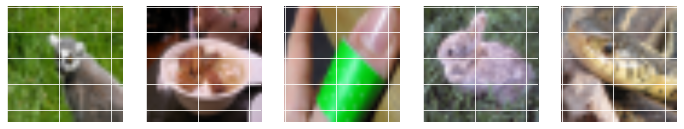

In [88]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=True)
    print(trainlabels[i])
print(trainimages[0].size())

In [18]:
#https://debuggercafe.com/satellite-image-classification-using-pytorch-resnet34/
import torch
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'outputs/model.pth')
    
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [89]:
import torchvision.models as models
import torch.nn as nn
def build_model(num_classes=125):
    model = models.resnet34(pretrained=False)     

    # change the final classification head, it is trainable
    model.fc = nn.Linear(512, num_classes)
    return model

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

lr = 0.001
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Computation device: {device}\n")
# build the model
model = build_model().to(device)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# loss function
criterion = nn.CrossEntropyLoss()

Computation device: cuda:0

21,348,797 total parameters.
21,348,797 training parameters.



In [20]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [21]:
# validation
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    # print the accuracy for each class after every epoch
    print('\n')
    for i in range(len(class_names)):
        print(f"Accuracy of class {class_names[i]}: {100*class_correct[i]/class_total[i]}")
    print('\n')
        
    return epoch_loss, epoch_acc

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 criterion, list(set(data_labels)))
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

TRAINING COMPLETE


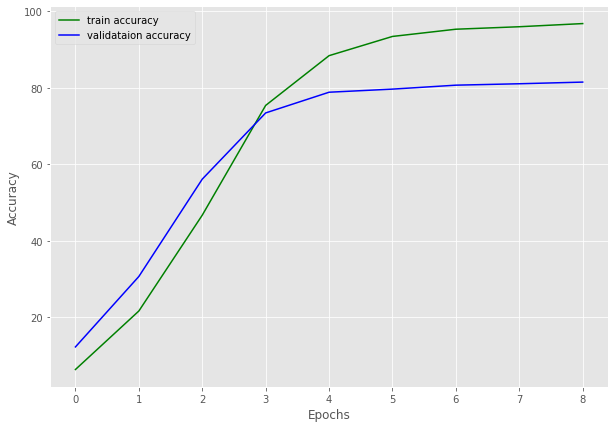

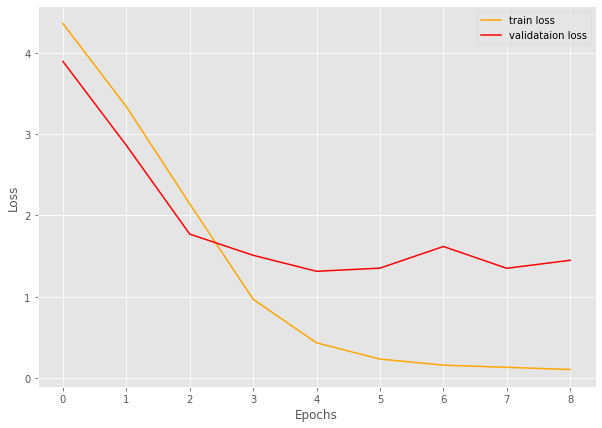

In [31]:
# save the trained model weights
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

In [53]:
import torch
import cv2
import torchvision.transforms as transforms

# list containing all the labels
labels = list(set(data_labels))

# initialize the model and load the trained weights
model = build_model().to(device)
print('[INFO]: Loading custom-trained weights...')
checkpoint = torch.load('outputs/model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4786, 0.4556, 0.4054],
        std=[0.2577, 0.2497, 0.2651]
    )
]) 

[INFO]: Loading custom-trained weights...


In [54]:
answer_list = []

ff_test = '/content/test/test/test'
files_name_test = os.listdir(ff_test)
for file_name in files_name_test:
    image = cv2.imread(ff_test + "/" + file_name)

    # convert to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class = labels[int(output_label.indices)]
    answer_list.append([file_name,int(pred_class)])
    #print(f"FILE: {file_name}, pred: {pred_class}")

In [55]:
from operator import itemgetter
result_sorted = sorted(answer_list, key=itemgetter(0))

In [56]:
#write
import csv  

header = ['image', 'label']

with open('Kim_Semyon.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for d in result_sorted:
      writer.writerow(d)

In [82]:
#read
rows = []
with open("Kim_Semyon.csv", 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
print(header)
print(rows)

['image', 'label']
[['img_0000.png', '86'], ['img_0001.png', '115'], ['img_0002.png', '33'], ['img_0003.png', '48'], ['img_0004.png', '2'], ['img_0005.png', '92'], ['img_0006.png', '44'], ['img_0007.png', '118'], ['img_0008.png', '33'], ['img_0009.png', '69'], ['img_0010.png', '97'], ['img_0011.png', '42'], ['img_0012.png', '45'], ['img_0013.png', '30'], ['img_0014.png', '69'], ['img_0015.png', '6'], ['img_0016.png', '66'], ['img_0017.png', '37'], ['img_0018.png', '107'], ['img_0019.png', '26'], ['img_0020.png', '11'], ['img_0021.png', '41'], ['img_0022.png', '64'], ['img_0023.png', '3'], ['img_0024.png', '91'], ['img_0025.png', '35'], ['img_0026.png', '34'], ['img_0027.png', '79'], ['img_0028.png', '14'], ['img_0029.png', '81'], ['img_0030.png', '58'], ['img_0031.png', '78'], ['img_0032.png', '119'], ['img_0033.png', '115'], ['img_0034.png', '62'], ['img_0035.png', '33'], ['img_0036.png', '117'], ['img_0037.png', '56'], ['img_0038.png', '53'], ['img_0039.png', '24'], ['img_0040.png', 